In [ ]:
#|default_exp reader

# About parsing pdz files 

> Let's bite off some bytes... 

Bruker `.pdz` files are binary files that contain both XRF spectral data (i.e. photon counts) and metadata. There is no official description of the file format yet, so in order to decode the bytes we need to do some reverse engineering. This will get a rather complicated, so fasten your seat belts... 

To get started we need to read the pdz file into memory as a numpy array of bytes using the `file_to_bytes()` function. 

In [ ]:
from read_pdz import file_to_bytes

In [ ]:
pdz_file = '/home/frank/Work/DATA/read-pdz-demodata/s0243V1962_XRF_28_White edge clothes underpainting (Al 38um filter).pdz'
pdz_bytes = file_to_bytes(pdz_file)
len(pdz_bytes)

8690

We see that this pdz file contains 8690 bytes. Let's take a look at the first 6 bytes...

In [ ]:
first_six_bytes = pdz_bytes[0:6]
first_six_bytes

array([b'\x19', b'', b'\x0e', b'', b'', b''], dtype='|S1')

The standard Python library for decoding bytes is [struct](https://docs.python.org/3/library/struct.html). In order to decode a sequence of bytes you can use the `struct.unpack()` function. As a first argument you need to supply a so-called format string. This is essentially a recipe that explains which bytes belong together and how to interpret the byte values of each group. 

We happen to know that the byte order in pdz files is *Little-Endian*. This is indicated with the `'<'` character. Next thing we know is that the first two bytes belong together and represent a 'short' integer value. This is indicated with the character `'h'`. The next group of four bytes represents an integer. This is indicated with the character `'i'`. For more detail on format characters see: [format-characters](https://docs.python.org/3/library/struct.html#format-characters).  

Armed with our format string `'<hi'` we are now ready to decode our first six bytes: 

In [ ]:
import struct 

In [ ]:
struct.unpack('<hi', first_six_bytes)

(25, 14)

Unfortunately the standard `struct.unpack()` function is not sufficient to decode pdz files. The reason for this is that Bruker pdz files contain different types of *variable byte length* segments that require more advanced decoding. An example of such a contraption is a variable length character string. The first four bytes of such a segment contain an integer value that represents the number of two byte characters following that belong to that string. Parsing such a string is then a two-step process. First read the size `n` of the string, and then read `2n` bytes that contain the actual string characters. Another example of a variable byte length construct is the division of a pdz file into blocks. Here again we need to read an integer value to decide how many following bytes belong the block. So far we have discovered three types of variable byte length constructs that are being used in pdz files: *file blocks*, *strings* and *tables*. 

An essential a first step in parsing a pdz file is a separation into it's consecutive file blocks. This can be done by applying the `get_blocks()` function to the `pdz_bytes` array.  

In [ ]:
from read_pdz import get_blocks

In [ ]:
block_list = get_blocks(pdz_bytes)

Detecting block sequence...
Ok!


Let's take a look at our `block_list` variable. Note that for long arrays not all values are printed... 

In [ ]:
block_list

[{'block_type': 25,
  'block_size': 14,
  'start': 0,
  'stop': 20,
  'file_size': 8690,
  'bytes': array([b'\x19', b'', b'\x0e', b'', b'', b'', b'p', b'', b'd', b'', b'z',
         b'', b'2', b'', b'5', b'', b'\x01', b'', b'', b''], dtype='|S1')},
 {'block_type': 1,
  'block_size': 228,
  'start': 20,
  'stop': 254,
  'file_size': 8690,
  'bytes': array([b'\x01', b'', b'\xe4', b'', b'', b'', b'\x08', b'', b'', b'', b'9',
         b'', b'0', b'', b'0', b'', b'F', b'', b'4', b'', b'9', b'', b'6',
         b'', b'9', b'', b'\x08', b'', b'', b'', b'S', b'', b'K', b'', b'5',
         b'', b'-', b'', b'4', b'', b'9', b'', b'6', b'', b'9', b'', b'-',
         b'-', b'-', b'A', b'}', b'', b'\x06', b'', b'', b'', b'A', b'',
         b'm', b'', b'p', b'', b't', b'', b'e', b'', b'k', b'', b'\x04',
         b'', b'', b'', b'R', b'', b'x', b'', b'B', b'', b'x', b'', b'\x03',
         b'\x08', b'\x07', b'', b'', b'', b'M', b'', b'o', b'', b'v', b'',
         b'a', b'', b'b', b'', b'l', b'', b'e', b

The example pdz file here contains exactly four consecutive blocks of bytes. Within each block the first two bytes of contain a (short) integer value that indicates the type of block, while the second four bytes contain an integer value that describes the length of that block. The first two bytes of the first block contain an integer value `25`. This indicates that the pdz format is 25. The next blocks are of type `1`, `2` and `3`. Block types `1` and `2` contain various instrument metadata, while block type `3` contains the actual spectral data. According to our local XRF guru Luc Megens a pdz file can contain multiple XRF spectra in separate type 3 blocks. Furthermore pdz files can contain type `4`, `5` and `6` blocks. For now we will ignore these... 

To enable the parsing of variable length strings and tables I created an *extended format string syntax* that besides standard struct format characters includes a capital `'S'` and `'T'` for strings and tables, and `'X'` for skipping bytes. Both `'S'` and `'X'` can be prefixed with and integer multiplier that indicates how many strings and bytes need to be parsed. For example `3X` will skip 3 bytes. If you need to skip an unknown amount of bytes at the end of an array you can put a wildcard `*X` multiplier at the end of the xformat string. These additional characters need to be separated from standard struct format strings with dashes `'-'`. Another important extension of the syntax is `'Z'`. This indicates at which position the actual spectral data of 2048 photon counts should be read.   

To read the information that is hidden in the bytes array of a block we can now apply the function `multiparse()`. This function needs as  required arguments an *extended syntax format string* `xformat` and an array of bytes `arr`. The xformat string functions as a recipe to decode the bytes array. The `xformat` strings for decoding block types `25`, `1`, `2` and `3` are stored in  the `PDZ_25_STRUCTURE_DICT` dictionary. Also included for each block is a `param_keys` list with our interpretation of the parsed values based on a comparison with other exports from Bruker software. In cases where we could not find out we put question marks.   

In [ ]:
from read_pdz import multiparse, PDZ_25_STRUCTURE_DICT

Before parsing the bytes from the file blocks it is informative to take look at the `PDZ_25_STRUCTURE_DICT` dictionary. This provides a complete specification of the pdz file format.  

```python
PDZ_25_STRUCTURE_DICT = {
    25:  {'xformat': 'hi-10X-i', 
          'param_keys': ['pdz_type', 'block_size', 'FileFormatString?', '??']}, 
    1:   {'xformat': 'hi-2S-6X-2S-h-S-T', 
          'param_keys': ['block_type', 'block_size', '??', 'SerialString', '??', '??', '??', '??', '??', '??', 
                         '??', '??', '??', '??', '??', '??', '??']}, 
    2:   {'xformat': 'hi3i8f-*X', 
          'param_keys': ['block_type', 'block_size', '??', 'RawCounts', 'ValidCounts', '??', '??', 
                         '??', 'ActiveTimeInSeconds', 'DeadTimeInSeconds', 'ResetTimeInSeconds', 
                         'LiveTimeInSeconds', 'TotalElapsedTimeInSeconds', '??', '??', '??']}, 
    3:   {'xformat': 'hi-3i9f7hfhfhfhf8hfhi-S-h-Z', 
          'param_keys': ['block_type', 'block_size', '??', 'RawCounts', 'ValidCounts', 
                         '??', '??', '??', 'ActiveTimeInSeconds', 'DeadTimeInSeconds', 
                         'ResetTimeInSeconds', 'LiveTimeInSeconds', 'XrayVoltageInkV', 'XrayFilamentCurrentInMicroAmps', 
                         'Filter1ElementAtomicNum', 'Filter1Thickness', 'Filter2ElementAtomicNum', 'Filter2Thickness', 
                         'Filter3ElementAtomicNum', 'Filter3Thickness', '??', 'DetectorTempInC', '??', 
                         '??', '??', 'eVPerChannel', '??', 'eVStart', 
                         'Year', 'Month', 'AM/PM code?', 'Day', 'Hour', 'Minutes', 'Seconds', 
                         '??', 'NosePressureInMilliBars', 'NumberOfChannels', 'NoseTemperatureInC', 
                         'TubeSpec?', '??', '2048 counts']}}
```

With this pdz file format specification we can decode the four blocks in the pdz file one by one. Let's parse the bytes of first block (type 25) of the pdz file with the corresponding `xformat` string and `param_keys` list.   

In [ ]:
xformat = PDZ_25_STRUCTURE_DICT[25]['xformat']
param_keys = PDZ_25_STRUCTURE_DICT[25]['param_keys']
xformat, param_keys

('hi-10X-i', ['pdz_type', 'block_size', 'FileFormatString?', '??'])

The recipe for reading this first file block is quite short: `h`: read a two byte integer, `i`: read a four byte integer, `10X`: skip ten bytes, `i`: read another four byte integer. 

In [ ]:
b0 = block_list[0]['bytes']
multiparse(xformat, b0);

,values
0,25
1,14
2,b'pdz25'
3,1


The `multiparse()` function can be given an optional third argument that is a list with the interpretation of each value.   

In [ ]:
multiparse(xformat, b0, param_keys=param_keys);

,values,param_keys
0,25,pdz_type
1,14,block_size
2,b'pdz25',FileFormatString?
3,1,??


Next we read the second block...

In [ ]:
b1 = block_list[1]['bytes']
xformat = PDZ_25_STRUCTURE_DICT[1]['xformat']
param_keys = PDZ_25_STRUCTURE_DICT[1]['param_keys'] 
xformat

'hi-2S-6s-2S-h-S-T'

In [ ]:
multiparse(xformat, b1, param_keys=param_keys);

,values,param_keys
0,1,block_type
1,228,block_size
2,900F4969,??
3,SK5-4969,SerialString
4,b'---A}\x00',??
5,Amptek,??
6,RxBx,??
7,2051,??
8,Movable,??
9,"[#1, 8.0.0.446]",??


This file block (type 1) contains values that seem to indicate serial numbers and probably software versions. Not sure  how useful this information is for us. Let's read the next block. 

In [ ]:
b2 = block_list[2]['bytes']
xformat = PDZ_25_STRUCTURE_DICT[2]['xformat']
param_keys = PDZ_25_STRUCTURE_DICT[2]['param_keys'] 
xformat

'hi3i8f-*X'

In [ ]:
multiparse(xformat, b2, param_keys=param_keys);

,values,param_keys
0,2,block_type
1,92,block_size
2,1,??
3,8139946,RawCounts
4,4976150,ValidCounts
5,0.0,??
6,0.0,??
7,55.394989,??
8,55.287003,ActiveTimeInSeconds
9,16.830002,DeadTimeInSeconds


File block `2` primarily contains instrumental data about measurement times and detector counts. 

Finally we parse file block type `3`. This block contains two parts. The first part contains spectral parameters, while the second part contains the actual spectral data (i.e. photon counts consisting of 2048 four byte integers.   

In [ ]:
b3 = block_list[3]['bytes']
b3_part1 = b3[0:-2054] # spectral parameters
b3_part2 = b3[-2054:] # counts 

xformat = PDZ_25_STRUCTURE_DICT[3]['xformat']
param_keys = PDZ_25_STRUCTURE_DICT[3]['param_keys'] 
xformat

'hi-3i9f7hfhfhfhf8hfhi-*Z'

In [ ]:
values,  arr = multiparse(xformat, b3, param_keys=param_keys)

,values,param_keys
0,3,block_type
1,8332,block_size
2,0,??
3,8139946,RawCounts
4,4976150,ValidCounts
5,0.0,??
6,0.0,??
7,55.394989,??
8,55.287003,ActiveTimeInSeconds
9,16.830002,DeadTimeInSeconds


We can see in the table above that the last row contains an array of 2048 integers with photon counts. This array can accessed by indexing the last element of the returned `values` list like so:     

In [ ]:
values[-1]

array([0, 0, 0, ..., 2, 2, 3])

The energy calibration for the individual 2048 detector channels is not stored in the pdz file but can be calculated from two spectral parameters:  `eVPerChannel` and `eVStart`. This is done automatically for you in the `extract_spectra()` function as explained in the previous section. If you want to save the spectral data to a .csv file then set the option `to_csv=True`. 

In [ ]:
from read_pdz import extract_spectrum

In [ ]:
df = extract_spectrum(pdz_file, to_csv=True)

Saving spectral data to: /home/frank/Work/DATA/read-pdz-demodata/s0243V1962_XRF_28_White edge clothes underpainting (Al 38um filter).pdz.csv


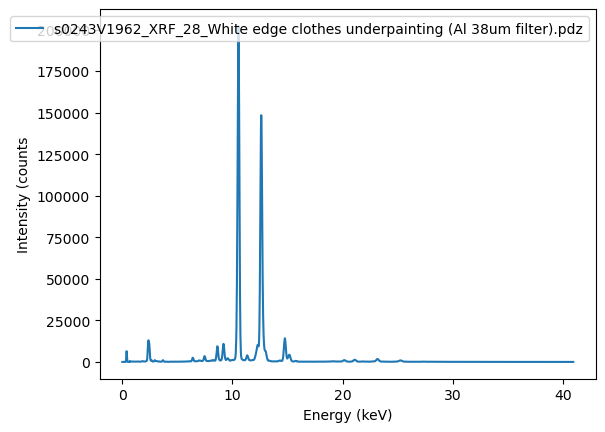

In [ ]:
ax = df.plot()
ax.set_xlabel('Energy (keV)')
ax.set_ylabel('Intensity (counts');

## FUNCTIONS 

In [ ]:
#|export 
import struct 
import numpy as np 
import os 
import re
import matplotlib.pyplot as plt
import pandas as pd 
from IPython.display import display

In [ ]:
#|export 

# 'hi-3i9f7hfhfhfhf8hfhi-S-h-Z'

PDZ_25_STRUCTURE_DICT = {
    25:  {'xformat': 'hi-10X-i', 
          'param_keys': ['pdz_type', 'block_size', 'FileFormatString?', '??']}, 
    1:   {'xformat': 'hi-2S-6s-2S-h-S-T', 
          'param_keys': ['block_type', 'block_size', '??', 'SerialString', '??', '??', '??', '??', '??', '??', 
                         '??', '??', '??', '??', '??', '??', '??']}, 
    2:   {'xformat': 'hi3i8f-*X', 
          'param_keys': ['block_type', 'block_size', '??', 'RawCounts', 'ValidCounts', '??', '??', 
                         '??', 'ActiveTimeInSeconds', 'DeadTimeInSeconds', 'ResetTimeInSeconds', 
                         'LiveTimeInSeconds', 'TotalElapsedTimeInSeconds', '??']}, 
    3:   {'xformat': 'hi-3i9f7hfhfhfhf8hfhi-*Z', 
          'param_keys': ['block_type', 'block_size', '??', 'RawCounts', 'ValidCounts', 
                         '??', '??', '??', 'ActiveTimeInSeconds', 'DeadTimeInSeconds', 
                         'ResetTimeInSeconds', 'LiveTimeInSeconds', 'XrayVoltageInkV', 'XrayFilamentCurrentInMicroAmps', 
                         'Filter1ElementAtomicNum', 'Filter1Thickness', 'Filter2ElementAtomicNum', 'Filter2Thickness', 
                         'Filter3ElementAtomicNum', 'Filter3Thickness', '??', 'DetectorTempInC', '??', 
                         '??', '??', 'eVPerChannel', '??', 'eVStart', 
                         'Year', 'Month', 'AM/PM code?', 'Day', 'Hour', 'Minutes', 'Seconds', 
                         '??', 'NosePressureInMilliBars', 'NumberOfChannels', 'NoseTemperatureInC', 
                         '??', 'Intensity_2048_channels']}}

# moved extract_spectra() function to legacy module 


def multiparse(xformat, arr, param_keys=None, verbose=True): 
    '''Parse segments in extendend format string `xformat` e.g. '<i5f-2S-T-3S-S-f' '''

    
    parts = re.split('-', xformat) 

    result_list = []
    for p in parts: 
        if 'S' in p:
            result, arr = read_strings(p, arr, verbose=False) 
        elif p == 'T': 
            result, arr = read_table(p, arr, verbose=False) 
        elif 'X' in p: 
            result, arr = skip_bytes(p, arr, verbose=False) 
            
        # four spectral data scenarios here: 

        # (1) 2048 channels at end of array and skip any bytes before
        elif p == '*Z': 
            # split array  
            n_channels = 2048 
            arr_0 = arr[:-n_channels*4] # head 
            arr_1 = arr[-n_channels*4:] # tail             
            skipped, _ = skip_bytes('*X', arr_0, verbose=False)
            counts, arr = read_counts('Z', arr_1 , verbose=False) # arr should now be empty 
            result = [skipped, counts]             
        # (2) 1024 channels at end of array and skip any bytes before
        elif p == '*z': 
            # split array  
            n_channels = 1024 
            arr_0 = arr[:-n_channels*4] # head 
            arr_1 = arr[-n_channels*4:] # tail 
            
            skipped, _ = skip_bytes('*X', arr_0, verbose=False)
            counts, arr = read_counts('z', arr_1 , verbose=False) # arr should now be empty 
            result = [skipped, counts]             
        # (3) 2048 channels not at end of array 
        elif p == 'Z': 
            result, arr = read_counts(p, arr, verbose=False)
            result = [result]
        # (4) 1024 channels not at end of array 
        elif p == 'z': 
            result, arr = read_counts(p, arr, verbose=False)
            result = [result]    
        
        else: 
            result, arr = parse(p, arr, verbose=False) 
            
        result_list.extend(result)   

    if verbose: 
        if param_keys == None: 
            result_df = pd.DataFrame({'values': result_list})
        else: 
            result_df = pd.DataFrame({'values': result_list, 'param_keys': param_keys})      
        display(result_df)

    return result_list, arr   

def prefix(format): 
    '''Prefix little endian byte order (<) to struct type format string if missing. '''

    if not format.startswith('<'): 
        format = f'<{format}'
    
    return format    

def file_to_bytes(pdz_file): 
    '''Read all bytes from filepath `pdz_file` into a byte array. 
    
    Returns: `pdz_arr` (numpy array of bytes)
    '''

    with open(pdz_file, 'rb') as fh: 
        blob = fh.read() 
        
    pdz_arr = np.array([v[0] for v in struct.iter_unpack('c', blob)])
    #pdz_arr = bytearray(blob)

    return pdz_arr 
    

def parse(format, arr, verbose=True): 
    '''Parse first bytes from bytes array `arr` into human readable text according to `format` string. 
    
    See struct library for format string specification. For example, '<ff' would result 
    the first 8 bytes to be converted into two Little-Endian floats. 
    
    Returns: `parsed` list and remaining bytes array of `tail_arr` unprocessed `values`.'''

    format = prefix(format) 
    size = struct.calcsize(format)
    buffer = arr[0:size]
    tail_arr = arr[size:]

    parsed = list(struct.unpack(format, buffer)) 

    if verbose: 
        print(parsed)
    
    return parsed, tail_arr

def read_strings(xformat, arr, verbose=True): 
    '''Parse `n` variable length character strings preceded by a length integer. 
     
    '''
    # get multiplier  
    if xformat == 'S': 
        n = 1
    else: 
        n = int(re.sub('(^\d+)S', '\g<1>', xformat))

    # parse strings 
    string_list = [] 
    while n > 0: 
        [length], arr = parse('<i', arr, verbose=False) # read length 
        n_bytes = 2 * length 

        # do some testing 
        assert (n_bytes > 1) and (type(n_bytes) is int), f'{n_bytes} is invalid string length' 
        
        char_list, arr = parse(f'<{n_bytes}c', arr, verbose=False) 
        string = b''.join(char_list).decode(encoding='utf-16') 
        string_list.append(string) 
        n = n -1 
        
    if verbose: 
        print(string_list) 

    return string_list, arr


def skip_bytes(xformat, arr, verbose=True): 
    '''Skip a number of bytes as specified in `xformat` string. 
    
    If multiplier is `*` then skip all. 
    '''

    # get multiplier  
    if xformat == 'X': 
        n_bytes = 1
    elif xformat == '*X': 
        n_bytes = len(arr)    
    else: 
        n_bytes = int(re.sub('(^\d+)X', '\g<1>', xformat))

    skipped = [b''.join(arr[0:n_bytes])] 

    arr = arr[n_bytes:] 

    if verbose: 
        print(skipped)

    return skipped, arr 
    

def read_table(xformat, arr, verbose=True): 
    '''Extract numbered table'''

    assert xformat == 'T', 'Incorrect format string'

    [table_length], arr = parse('<i', arr, verbose=False) 

    table = []
    for i in range(table_length): 
        [num], arr = parse('<h', arr, verbose=False)  
        [string], arr = read_strings('S', arr, verbose=False)
        table.append([f'#{num}', string]) 
        
    if verbose: 
        print(table)

    return table, arr


def read_counts(xformat, arr, verbose=True): 
    '''Extract counts. '''

    assert xformat == 'Z'  or xformat == 'z', 'Incorrect spectral data format string. Should be `Z` or `z`' 
    
    if xformat == 'Z': 
        n_channels = 2048 
    elif xformat == 'z': 
        n_channels = 1024 
        
    # make struct compatible format string 
    _format = f'<{n_channels}i'

    counts, arr = parse(_format, arr, verbose=False) 
    counts = np.array(counts)
        
    if verbose: 
        print(counts)

    return counts, arr
    

def get_block_at(pdz_arr, start): 
    '''Read first data block from bytes array `pdz_arr` from index position `start`. 

    Assumes that first 4 bytes are (block type and size)
    
    Returns: `block_dict`, `block` 
    '''

    file_size = len(pdz_arr)
    
    [block_type, block_size], arr = parse('hi', pdz_arr[start:], verbose=False)
    
    stop = start + block_size + 6 # four bytes extra due to `dtype` and `size` shorts plus two empty pad bytes? 

    # read block bytes
    arr = pdz_arr[start:stop] 
    
    block_dict = {'block_type': block_type, 'block_size': block_size, 'start': start, 'stop': stop, 
                  'file_size': file_size, 'bytes': arr}

    return block_dict


def get_blocks(pdz_bytes, verbose=True): 
    '''Parse `pdz_byte_array` into consequtive blocks. ''' 

    if verbose: 
        print('Detecting block sequence...')
    
    start = 0 
    total_size = len(pdz_bytes) 

    block_list = [] 
    while start < total_size: 
        block_dict = get_block_at(pdz_bytes, start)
        start = block_dict['stop']
        block_list.append(block_dict)

    else:
        if start == total_size: 
            if verbose: 
                print('Ok!')
        else: 
            print('Error while reading last block! ')
            print(f'Stop index: {start} does not match total file size: {total_size}')
        
    return block_list


def get_blocktypes(block_list): 
    '''Extract `block_types` list from `block_list`. '''
    
    block_types = []

    for block_dict in block_list: 
        t = block_dict['block_type']
        block_types.append(t)

    return block_types


#|hide 

## Comparison with .csv export 

Let's take a look at the `Complete.csv` file first, to see what type of info we can expect when we try to parse the bytes in the pdz file.  

    [0] Bruker AXS HMP Instrument Tools Complete CSV
    [1] FileName,C:\00-VGM\cal tool kit test\s0243V1962_XRF_28_White edge clothes underpainting (Al 38um filter).pdz
    [2] SerialString,SK5-4969
    [3] TubeTargetElement,45
    [4] NumberOfSpectra,1
    [5] SampleID,
    [6] AcquisitionDateTime,8/23/2022 11:54:32 AM
    [7] TotalElapsedTimeInSeconds,112.7783
    [8] AnodeTakeOffAngle,45
    [9] SampleIncidenceAngle,45
    [10] BeThicknessInMicroMeters,125
    [11] SampleTakeOffAngle,65
    [12] XrayVoltageInkV,40,
    [13] XrayFilamentCurrentInMicroAmps,8,
    [14] RawCounts,8139946,
    [15] ValidCounts,4976150,
    [16] eVPerChannel,20,
    [17] StartingKeV,0.002356571,
    [18] ZeroOffsetInKeV,-0.002356571,
    [19] StartingChannel,0.1178286,
    [20] NumberOfChannels,2048,
    [21] CountsPerSecond,147230.7,
    [22] XilinxFirmwareVersion,,
    [23] Filter1ElementAtomicNum,13,
    [24] Filter1Thickness,38,
    [25] Filter2ElementAtomicNum,0,
    [26] Filter2Thickness,0,
    [27] Filter3ElementAtomicNum,0,
    [28] Filter3Thickness,0,
    [29] AcquisitionDateTime,8/23/2022 11:54:32 AM,
    [30] LiveTimeInSeconds,24.532,
    [31] DeadTimeInSeconds,16.83,
    [32] ResetTimeInSeconds,13.92501,
    [33] DetectorTempInC,37.5,
    [34] AmbientTempInF,0,
    [35] NosePressureInMilliBars,1017,
    [36] NoseTemperatureInC,38,
    [37] ActiveTimeInSeconds,55.287,
    [38] PacketTimeInSeconds,69.21201,
    [39] CommunicationTimeInSeconds,,
    [40] ElapsedClockTimeInSeconds,112.7783,
    [41] Spectrum:ChannelNumber,ChannelStartInKeV,ChannelCount
    [42] 1,0.002356571,0
    [43] 2,0.02235657,0
    [44] 3,0.04235657,0
    [45] 4,0.06235657,0
    [46] 5,0.08235657,0
    [47] 6,0.1023566,0
    [48] 7,0.1223566,0
    [49] 8,0.1423566,0
    ...
    [2085] 2044,40.86236,0
    [2086] 2045,40.88235,3
    [2087] 2046,40.90236,2
    [2088] 2047,40.92236,2
    [2089] 2048,40.94236,3